In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Manufacturing

# `stocks` dataset

In [2]:
stocks = pd.read_csv("stocks.csv")  # Load stocks dataset

In [3]:
stocks["q"] = pd.to_datetime(stocks["q"])  # Update 'q' column so that it is a date

# `us_firms` dataset

In [4]:
us_firms = pd.read_csv("usfirms2022.csv")  # Load US firms dataset

In [5]:
# Rename columns to more familiar names
us_firms = us_firms.rename(columns = {"Ticker": "firm", "Sector NAICS\nlevel 1": "industry"})

# Merge `us_firms` and `stock` dataset

In [6]:
stocks = stocks.merge(us_firms[["firm", "industry"]], on="firm")

In [7]:
stocks = stocks[stocks["industry"] != "-"]

# Set multiindex

In [8]:
multiindex = ["industry", "firm", "q"]

In [9]:
stocks.set_index(multiindex, inplace=True)  # Set multidimensional indices

In [10]:
stocks = stocks.sort_values(by=multiindex)  # Sort indices

In [11]:
stocks.head()

revenue  cogs  sgae  \
industry                        firm q                                 
Accommodation and Food Services ARKR 2000-01-01      NaN   NaN   NaN   
                                     2000-04-01      NaN   NaN   NaN   
                                     2000-07-01      NaN   NaN   NaN   
                                     2000-10-01      NaN   NaN   NaN   
                                     2001-01-01      NaN   NaN   NaN   

                                                 otheropexp  extraincome  \
industry                        firm q                                     
Accommodation and Food Services ARKR 2000-01-01         NaN          NaN   
                                     2000-04-01         NaN          NaN   
                                     2000-07-01         NaN          NaN   
                                     2000-10-01         NaN          NaN   
                                     2001-01-01         NaN          NaN   

                                                 finexp  incometax  \
industry                        firm q                               
Accommodation and Food Services ARKR 2000-01-01     NaN        NaN   
                                     2000-04-01     NaN        NaN   
                                     2000-07-01     NaN        NaN   
                                     2000-10-01     NaN        NaN   
                                     2001-01-01     NaN        NaN   

                                                 totalassets  \
industry                        firm q                         
Accommodation and Food Services ARKR 2000-01-01          NaN   
                                     2000-04-01          NaN   
                                     2000-07-01          NaN   
                                     2000-10-01          NaN   
                                     2001-01-01          NaN   

                                                 totalliabilities  shortdebt  \
industry                        firm q                                         
Accommodation and Food Services ARKR 2000-01-01               NaN        NaN   
                                     2000-04-01               NaN        NaN   
                                     2000-07-01               NaN        NaN   
                                     2000-10-01               NaN        NaN   
                                     2001-01-01               NaN        NaN   

                                                 longdebt  stockholderequity  \
industry                        firm q                                         
Accommodation and Food Services ARKR 2000-01-01       NaN                NaN   
                                     2000-04-01       NaN                NaN   
                                     2000-07-01       NaN                NaN   
                                     2000-10-01       NaN                NaN   
                                     2001-01-01       NaN                NaN   

                                                 adjprice  originalprice  \
industry                        firm q                                     
Accommodation and Food Services ARKR 2000-01-01       NaN            NaN   
                                     2000-04-01       NaN            NaN   
                                     2000-07-01       NaN            NaN   
                                     2000-10-01       NaN            NaN   
                                     2001-01-01       NaN            NaN   

                                                 sharesoutstanding  \
industry                        firm q                               
Accommodation and Food Services ARKR 2000-01-01                NaN   
                                     2000-04-01                NaN   
                                     2000-07-01                NaN   
                                     2000-10-01                NaN

# Get finance metrics

In [12]:
stocks["cc returns"] = np.log(stocks["adjprice"]) - np.log(stocks.groupby(level=1)["adjprice"].shift(1))

In [13]:
stocks["market value"] = stocks["originalprice"] * stocks["sharesoutstanding"]

In [14]:
stocks["book value"] = stocks["totalassets"] - stocks["totalliabilities"]

In [15]:
stocks["book-to-market ratio"] = stocks["book value"] / stocks["market value"]

In [16]:
stocks["ebit"] = stocks["revenue"] - stocks["cogs"] - stocks["sgae"] - stocks["otheropexp"]

In [17]:
stocks["sales annual growth"] = stocks["revenue"] / stocks.groupby(level=1)["revenue"].shift(4) - 1

In [18]:
stocks["operating profit growth"] = stocks["ebit"] / stocks.groupby(level=1)["ebit"].shift(4) - 1

In [19]:
stocks["operating profit margin"] = stocks["ebit"] / stocks["revenue"]

In [20]:
stocks["short financial leverage"] = stocks["shortdebt"] / stocks["totalassets"]

In [21]:
stocks["long financial leverage"] = stocks["longdebt"] / stocks["totalassets"]

In [22]:
stocks["net income"] = stocks["ebit"] - stocks["finexp"] - stocks["incometax"] + stocks["extraincome"]

In [23]:
stocks["eps"] = stocks["net income"] / stocks["sharesoutstanding"]

In [24]:
stocks["epsp"] = stocks["eps"] / stocks["originalprice"]

In [25]:
stocks.head()

revenue  cogs  sgae  \
industry                        firm q                                 
Accommodation and Food Services ARKR 2000-01-01      NaN   NaN   NaN   
                                     2000-04-01      NaN   NaN   NaN   
                                     2000-07-01      NaN   NaN   NaN   
                                     2000-10-01      NaN   NaN   NaN   
                                     2001-01-01      NaN   NaN   NaN   

                                                 otheropexp  extraincome  \
industry                        firm q                                     
Accommodation and Food Services ARKR 2000-01-01         NaN          NaN   
                                     2000-04-01         NaN          NaN   
                                     2000-07-01         NaN          NaN   
                                     2000-10-01         NaN          NaN   
                                     2001-01-01         NaN          NaN   

                                                 finexp  incometax  \
industry                        firm q                               
Accommodation and Food Services ARKR 2000-01-01     NaN        NaN   
                                     2000-04-01     NaN        NaN   
                                     2000-07-01     NaN        NaN   
                                     2000-10-01     NaN        NaN   
                                     2001-01-01     NaN        NaN   

                                                 totalassets  \
industry                        firm q                         
Accommodation and Food Services ARKR 2000-01-01          NaN   
                                     2000-04-01          NaN   
                                     2000-07-01          NaN   
                                     2000-10-01          NaN   
                                     2001-01-01          NaN   

                                                 totalliabilities  shortdebt  \
industry                        firm q                                         
Accommodation and Food Services ARKR 2000-01-01               NaN        NaN   
                                     2000-04-01               NaN        NaN   
                                     2000-07-01               NaN        NaN   
                                     2000-10-01               NaN        NaN   
                                     2001-01-01               NaN        NaN   

                                                 ...  book-to-market ratio  \
industry                        firm q           ...                         
Accommodation and Food Services ARKR 2000-01-01  ...                   NaN   
                                     2000-04-01  ...                   NaN   
                                     2000-07-01  ...                   NaN   
                                     2000-10-01  ...                   NaN   
                                     2001-01-01  ...                   NaN   

                                                 ebit  sales annual growth  \
industry                        firm q                                       
Accommodation and Food Services ARKR 2000-01-01   NaN                  NaN   
                                     2000-04-01   NaN                  NaN   
                                     2000-07-01   NaN                  NaN   
                                     2000-10-01   NaN                  NaN   
                                     2001-01-01   NaN                  NaN   

                                                 operating profit growth  \
industry                        firm q                                     
Accommodation and Food Services ARKR 2000-01-01                      NaN   
                                     2000-04-01                      NaN   
                                     2000-07-01                      NaN   
                                    

# General questions

## Firm size

### Market value

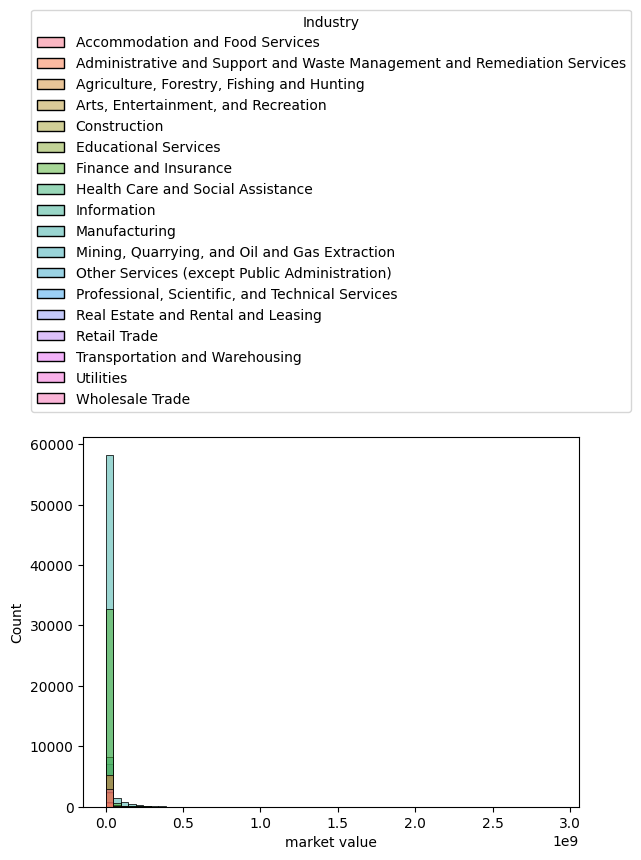

In [26]:
hist = sns.histplot(
    stocks, x="market value", bins=60,
    hue=stocks.index.get_level_values("industry"), common_norm=False
)

sns.move_legend(hist, "lower center", bbox_to_anchor=(0.5, 1.05), title="Industry")

plt.show()

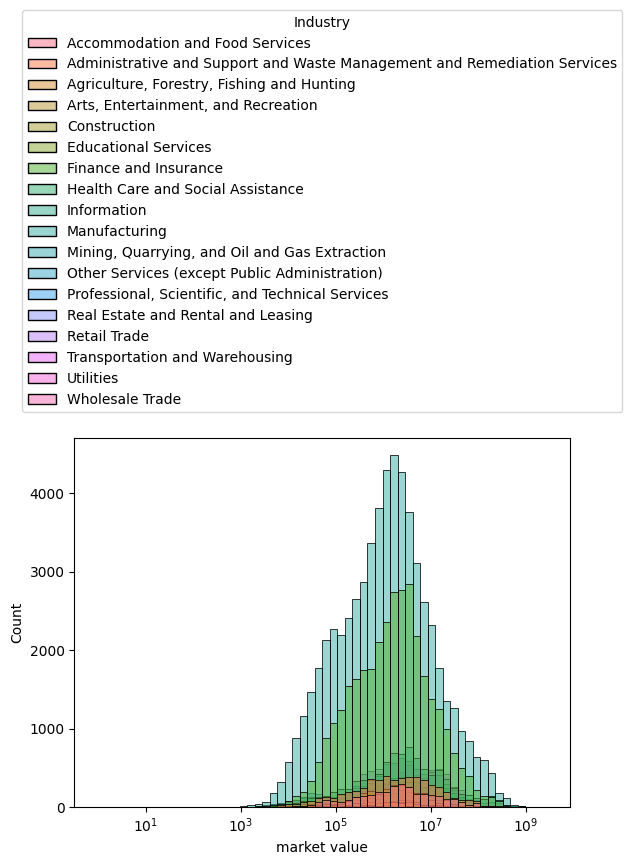

In [27]:
# Log scale net income
hist = sns.histplot(
    stocks, x="market value", bins=60,
    hue=stocks.index.get_level_values("industry"), common_norm=False, log_scale=True
)

sns.move_legend(hist, "lower center", bbox_to_anchor=(0.5, 1.05), title="Industry")

plt.show()

### Book value 

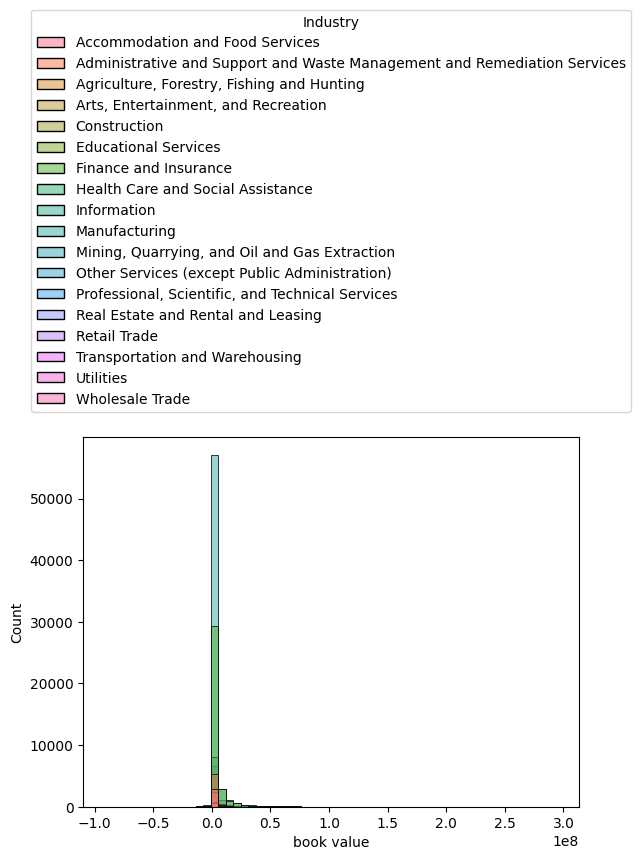

In [28]:
hist = sns.histplot(
    stocks, x="book value", bins=60,
    hue=stocks.index.get_level_values("industry"), common_norm=False
)

sns.move_legend(hist, "lower center", bbox_to_anchor=(0.5, 1.05), title="Industry")

plt.show()

## Sales performance and profitability

### Net income

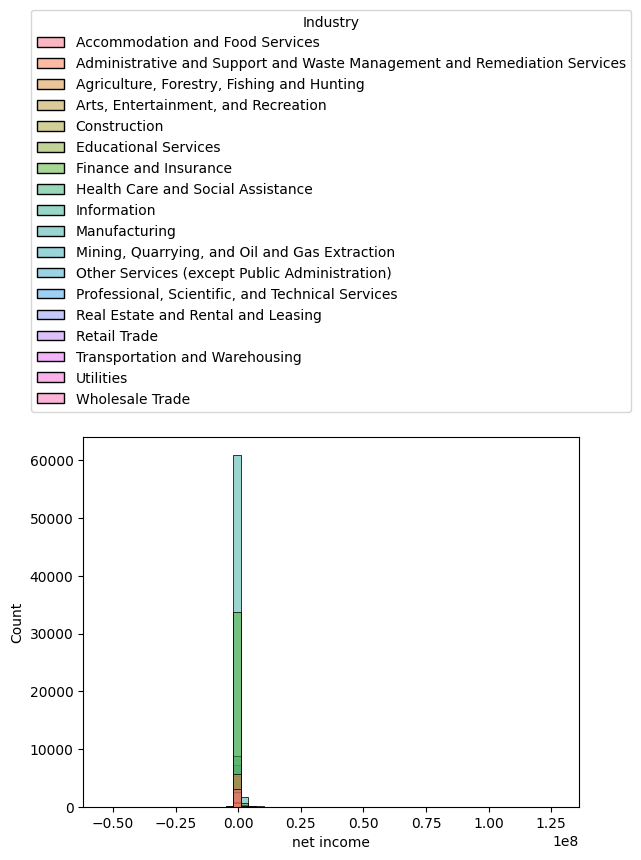

In [29]:
hist = sns.histplot(
    stocks, x="net income", bins=60,
    hue=stocks.index.get_level_values("industry"), common_norm=False
)

sns.move_legend(hist, "lower center", bbox_to_anchor=(0.5, 1.05), title="Industry")

plt.show()

### Earnings per share

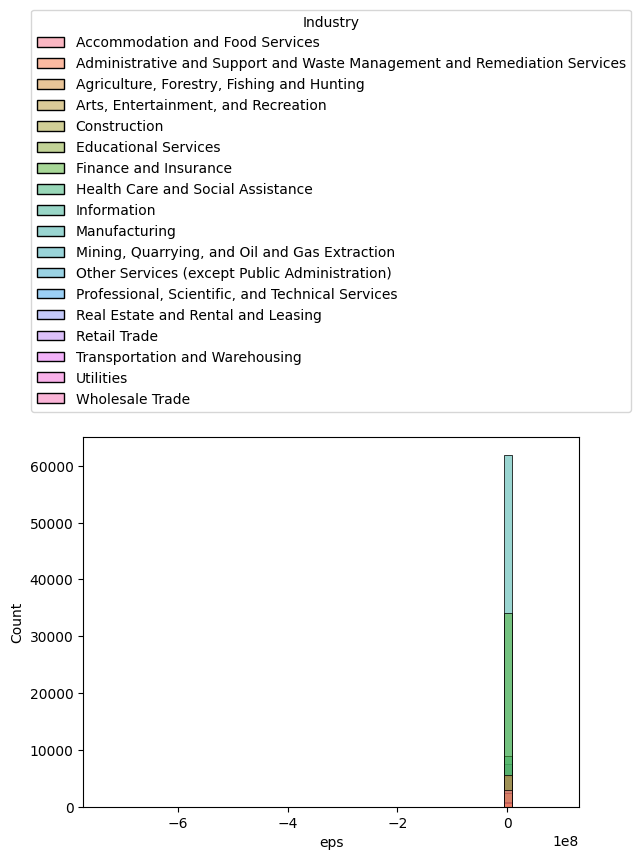

In [30]:
hist = sns.histplot(
    stocks, x="eps", bins=60,
    hue=stocks.index.get_level_values("industry"), common_norm=False
)

sns.move_legend(hist, "lower center", bbox_to_anchor=(0.5, 1.05), title="Industry")

plt.show()

# Specific questions

## Descriptive statistics

### Firms by industry

In [31]:
last_quarter = stocks.index.levels[2][-1]

In [32]:
stocks_last_quarter = stocks.loc[:, :, last_quarter]

In [33]:
stocks_last_quarter

revenue       cogs      sgae  \
industry                        firm                                   
Accommodation and Food Services ARKR    53218.0        0.0   47797.0   
                                ARMK  4127378.0  3747828.0  231664.0   
                                BBQ     79938.0        0.0   75445.0   
                                BDL     40675.0        0.0   38592.0   
                                BH      92367.0    54268.0   24382.0   
...                                         ...        ...       ...   
Wholesale Trade                 WEYS    74359.0    44589.0   24105.0   
                                WLFC    78075.0        0.0   52567.0   
                                WSO   2133755.0  1538222.0  314753.0   
                                WSTG    67863.0    55377.0    8379.0   
                                ZEUS   709176.0   560546.0   94765.0   

                                      otheropexp  extraincome   finexp  \
industry                        firm                                     
Accommodation and Food Services ARKR         0.0        992.0    253.0   
                                ARMK         0.0       -152.0  91466.0   
                                BBQ          0.0        836.0    165.0   
                                BDL          0.0        -49.0    177.0   
                                BH          20.0    -105241.0   4945.0   
...                                          ...          ...      ...   
Wholesale Trade                 WEYS         0.0        181.0    -78.0   
                                WLFC         0.0       1469.0  16023.0   
                                WSO      -6317.0     -32949.0   1110.0   
                                WSTG         0.0       -442.0      7.0   
                                ZEUS         0.0        -15.0   2271.0   

                                      incometax  totalassets  \
industry                        firm                           
Accommodation and Food Services ARKR      905.0     182780.0   
                                ARMK    15939.0   14988770.0   
                                BBQ       985.0     234605.0   
                                BDL        22.0     139409.0   
                                BH     -22709.0     773352.0   
...                                         ...          ...   
Wholesale Trade                 WEYS     1429.0     268760.0   
                                WLFC     5046.0    2396383.0   
                                WSO     60481.0    3788592.0   
                                WSTG      867.0     179003.0   
                                ZEUS    13955.0    1086116.0   

                                      totalliabilities  shortdebt  ...  \
industry                        firm                               ...   
Accommodation and Food Services ARKR          123286.0    13035.0  ...   
                                ARMK        12073509.0   148359.0  ...   
                                BBQ           163260.0    16301.0  ...   
                                BDL            67057.0     5214.0  ...   
                                BH            267616.0    17019.0  ...   
...                                                ...        ...  ...   
Wholesale Trade                 WEYS           65323.0     8711.0  ...   
                                WLFC         2021489.0        0.0  ...   
                                WSO          1568817.0    88600.0  ...   
                                WSTG          124590.0      999.0  ...   
                                ZEUS          586557.0     6127.0  ...   

                                      book-to-market ratio      ebit  \
industry                        firm                                   
Accommodation and Food Services ARKR              0.930434    5421.0   
                                ARMK              0.369902  147886.0   
                                BBQ               0.6365

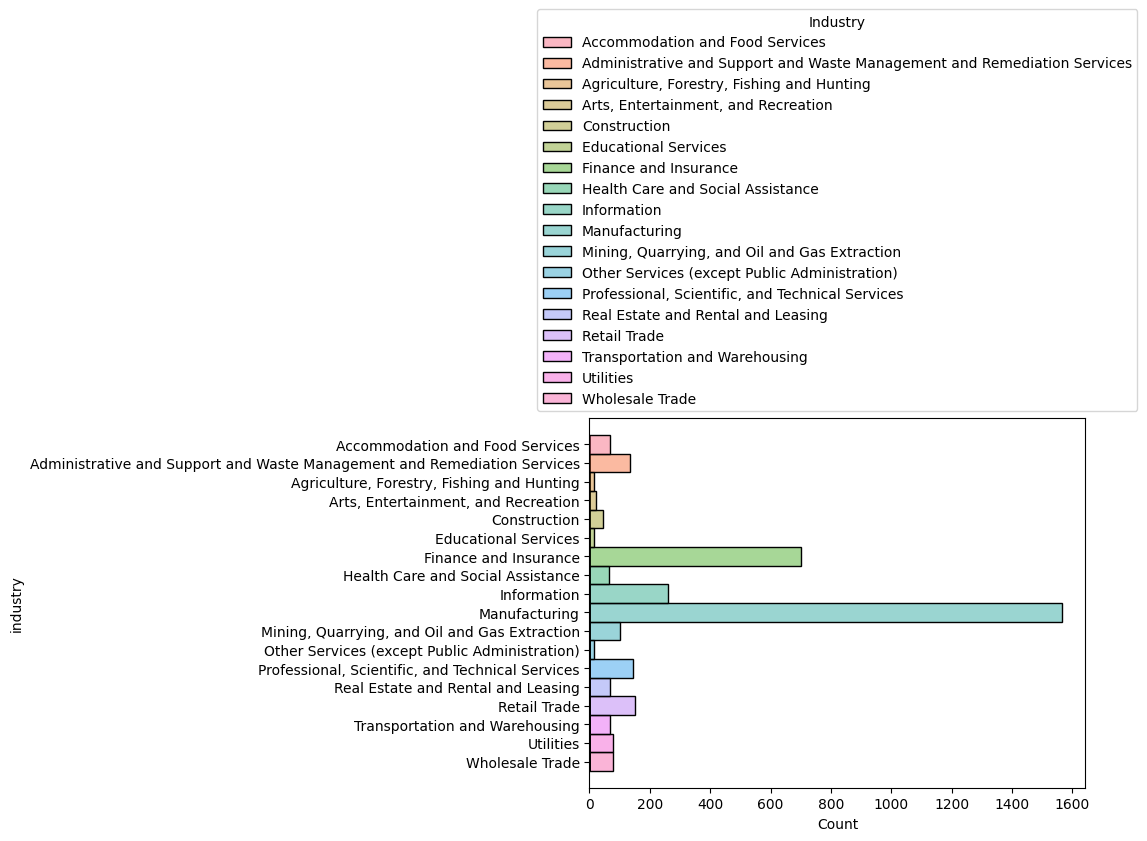

In [34]:
hist = sns.histplot(
    data=stocks_last_quarter,
    y=stocks_last_quarter.index.get_level_values("industry"),
    hue=stocks_last_quarter.index.get_level_values("industry"),
    common_norm=False
)

sns.move_legend(hist, "lower center", bbox_to_anchor=(0.5, 1.0), title="Industry")

plt.show()

### Book value by industry

In [ ]:
hist = sns.histplot(
    stocks_last_quarter, x="book value", bins=60,
    hue=stocks_last_quarter.index.get_level_values("industry"), common_norm=False
)

sns.move_legend(hist, "lower center", bbox_to_anchor=(0.5, 1.0), title="Industry")

plt.show()

### Market value by industry

In [ ]:
hist = sns.histplot(
    stocks_last_quarter, x="market value", bins=60,
    hue=stocks_last_quarter.index.get_level_values("industry"), common_norm=False
)

sns.move_legend(hist, "lower center", bbox_to_anchor=(0.5, 1.0), title="Industry")

plt.show()

By examining the above histograms, it can be seen that both the market value and book value of the firms across different industries are skewed to the left. Because of this, to get a sense of the typical of these metrics, the median of both metrics is measured.

In [ ]:
stocks_last_quarter.index.levels[0].values

In [ ]:
typical_market_value = {
    industry: stocks_last_quarter.loc[industry, "market value"].median()
    for industry in stocks_last_quarter.index.levels[0].values
}

In [ ]:
typical_market_value = pd.DataFrame(
    data={
        "industry": typical_market_value.keys(),
        "median market value": typical_market_value.values()
    }
)

In [ ]:
typical_book_value = {
    industry: stocks_last_quarter.loc[industry, "book value"].median()
    for industry in stocks_last_quarter.index.levels[0].values
}

In [ ]:
typical_book_value = pd.DataFrame(
    data={
        "industry": typical_book_value.keys(),
        "median book value": typical_book_value.values()
    }
)

In [ ]:
typical_book_value.head()

In [ ]:
bar = sns.barplot(data=typical_market_value, x="median market value", y="industry", hue="industry", dodge=False)

sns.move_legend(bar, "lower center", bbox_to_anchor=(0.5, 1.0), title="Industry")

plt.show()

In [ ]:
bar = sns.barplot(data=typical_book_value, x="median book value", y="industry", hue="industry", dodge=False)

sns.move_legend(bar, "lower center", bbox_to_anchor=(0.5, 1.0), title="Industry")

plt.show()

In [ ]:
typical_firm_size = typical_market_value.merge(typical_book_value, on="industry")

In [ ]:
typical_firm_size.head()

## Statistical modeling

In [ ]:
stocks_manufacturing = stocks.loc["Manufacturing"]

In [ ]:
stocks_manufacturing.head()

In [ ]:
factors = [
    "net income",
    "operating profit margin",
    "operating profit growth",
    "sales annual growth", 
    "ebit",
]

In [ ]:
sns.pairplot(
    stocks_manufacturing[[
        "cc returns", 
        "eps", 
        "net income",
        "operating profit growth",
        "sales annual growth"
    ]].dropna(),
    # hue=stocks_manufacturing.index.get_level_values("firm")
)

---

# EDA

## US firms by indutry

---

# Glossary

## Firm size measures

$$
\text{book value} = \text{total assets} - \text{total liabilities}
$$

$$
\begin{aligned}
\text{market value} &= \text{historical stock price} \times |\text{shares}|\\
                    &= \text{original price} \times \text{share outstanding}
\end{aligned}
$$

## Profit margin measures

$$
\text{operating profit margin} = \frac{\text{operating profit}}{\text{sales}}
$$

$$
\text{operating profit} = \text{revenue} - \text{cogs} - \text{sgae}
$$

$$
\text{cogs} = \text{cost of good sold} = \text{variable cost}
$$

$$
\text{sgae} = \text{sales and general administrative expenses} = \text{fixe costs}
$$

$$
\begin{aligned}
\text{ebit} &= \text{earnings before interest and taxes} = \text{opearting profit} \\
            &= \text{revenue} - \text{cogs} - \text{sgae} - \text{otheropexp}
\end{aligned}
$$

$$
\text{operating profit margin} = \text{opm} = \frac{\text{ebit}}{\text{revenue}}
$$

$$
\text{profit margin} = \frac{\text{net income}}{\text{sales}}
$$